In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading both the training and testing dataset:

In [ ]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [ ]:
x_train, y_train,x_test, y_test = load_data()

In [ ]:
x_train.shape


(9690, 2304)

In [ ]:
y_train.shape


(9690, 1)

In [ ]:
x_test.shape


(3090, 2304)

In [ ]:
y_test.shape

(3090, 1)

In [ ]:
x_train_normalized, x_test_normalized=np.array(x_train)/255, np.array(x_test)/255
x_train_reshaped = x_train_normalized.reshape((x_train_normalized.shape[0], 48, 48, 1))
x_test_reshaped = x_test_normalized.reshape((x_test_normalized.shape[0], 48, 48, 1))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)

    try:
        probabilities=model.predict_proba(X_train)
        aucs= []
        for i in range(len(unique_labels)):
            fpr_dt, tpr_dt, _ = roc_curve((y_test == unique_labels[i]).astype(int), probabilities[:, i])
            roc_auc_dt = auc(fpr_dt, tpr_dt)
            aucs.append(roc_auc_dt)
    except:
        aucs = 0
    auc_df = pd.DataFrame({'AUC': aucs}, index=unique_labels)

    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})

    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])

    return result_df

https://www.tensorflow.org/tutorials/images/cnn

https://colab.research.google.com/drive/1uWZQ-lzAk5308YVjMW5XaZcS_3zmGSgN?usp=sharing

In [ ]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn(input_shape=input_shape, num_classes=10, dense_units=64, learning_rate=0.001, loss='sparse_categorical_crossentropy',
               kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    # pooling input layer
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


In [ ]:
def plotHistory(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd

results_df=pd.DataFrame()

def cross_validate_and_evaluate(x_train, y_train, x_test, y_test,
                                 model,name='Model', epochs=10, batch_size=64):
    history = model.fit(x_train, y_train, epochs=epochs,
                         batch_size=batch_size, validation_data=(x_test_reshaped, y_test), verbose=0)

    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    test_accuracy = accuracy_score(model.predict(x_test), y_test)
    train_accuracy = accuracy_score(model.predict(x_train), y_train)
    cv_accuracy = cross_val_score(model, x_train, y_train, cv=kf, scoring='accuracy', verbose=0).mean()

    results_dict = {'Model': name,
                    'CV10_Mean_Accuracy': cv_accuracy,
                    'Train_accuracy': train_accuracy,
                    'Test_accuracy': test_accuracy,
                    }
    global results_df
    results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
    return results_dict, history


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
num_classes=10
epochs=10
batch_size=64
kernel=(3, 3)
strides=(2, 2)
input_shape=x_train_reshaped.shape[1:]

C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\270069022.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

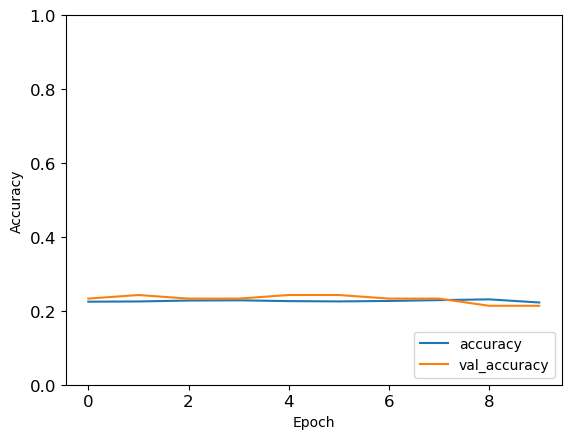

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

num_classes=10
epochs=10
batch_size=64
kernel=(3, 3)
strides=(2, 2)
input_shape=x_train_reshaped.shape[1:]
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.1)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.1',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\243094207.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

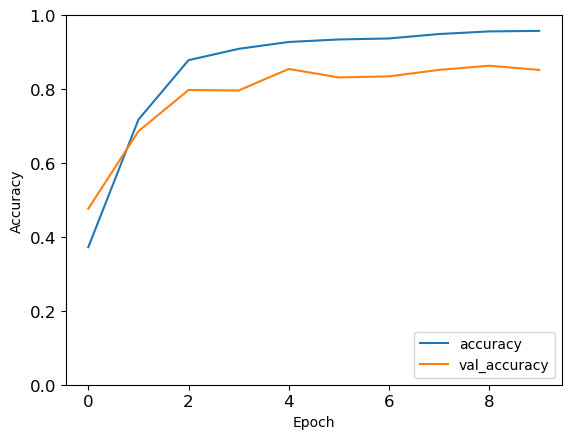

In [ ]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                        num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.01)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.01',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\2504390988.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

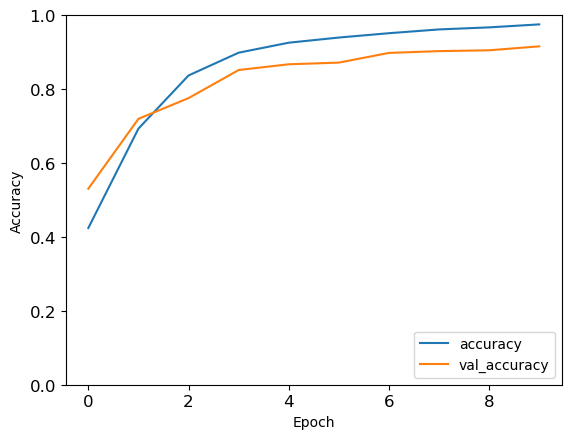

In [ ]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.001',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\3111095439.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

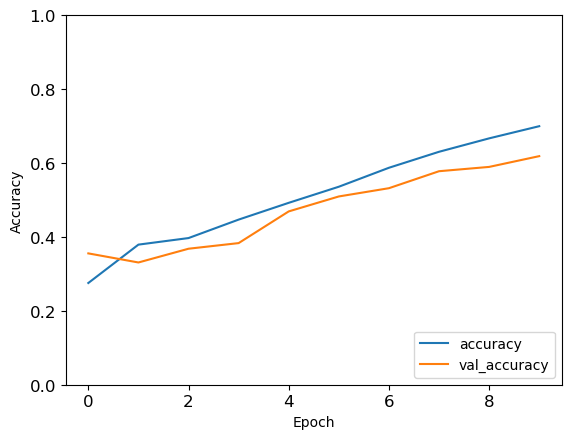

In [ ]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                        num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.0001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.0001',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\283570719.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

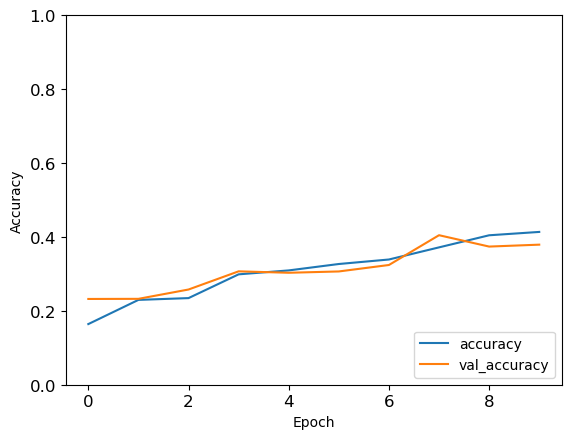

In [ ]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.00001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M1 LR 0.00001',epochs,batch_size)
plotHistory(history)

In [ ]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.213416,0.204334,0.213592
1,M1 LR 0.01,0.672239,0.954902,0.851780
2,M1 LR 0.001,0.597317,0.983282,0.915534
3,M1 LR 0.0001,0.388751,0.710010,0.618447
4,M1 LR 0.00001,0.243860,0.415789,0.378964


In [ ]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex(input_shape=input_shape, num_classes=10, dense_units=64,
                   learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\486445807.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex, input_shape=input_shape,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

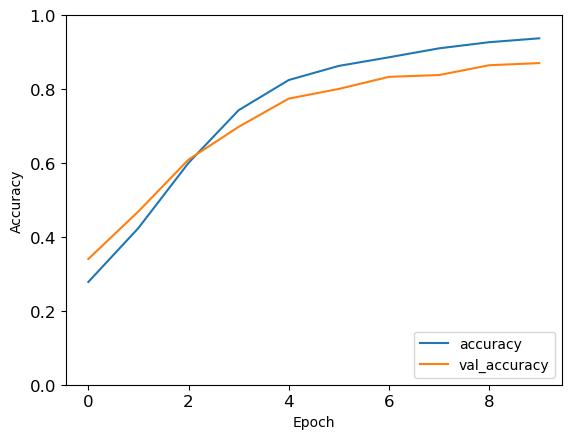

In [ ]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M2 LR 0.001',epochs,batch_size)
plotHistory(history)

In [ ]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex2(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\2738745057.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, input_shape=input_shape,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

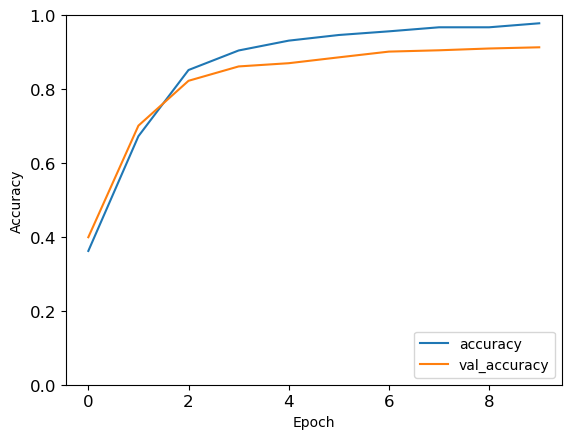

In [ ]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex2, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M3 LR 0.001 softmax',epochs,batch_size)
plotHistory(history)

https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html#scikeras.wrappers.KerasClassifier


#### Trying different activation fuctions on the output layer

In [ ]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex3(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\2434522372.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex3, input_shape=input_shape,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

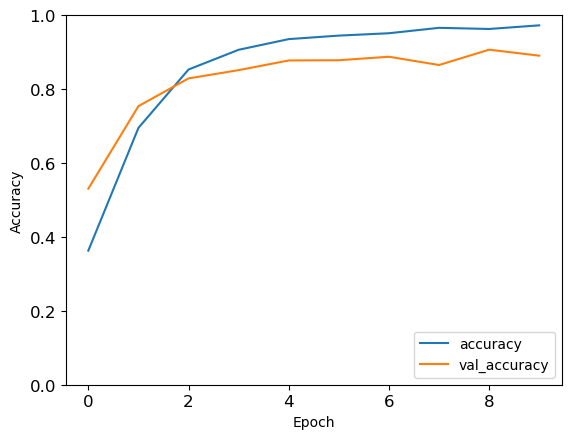

In [ ]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex3, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M3 LR 0.001 sigmoid',epochs,batch_size)
plotHistory(history)

In [ ]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex4(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='linear'))  #basically no activation functon as it has no effect on the weights
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\2709864942.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex4, input_shape=input_shape,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

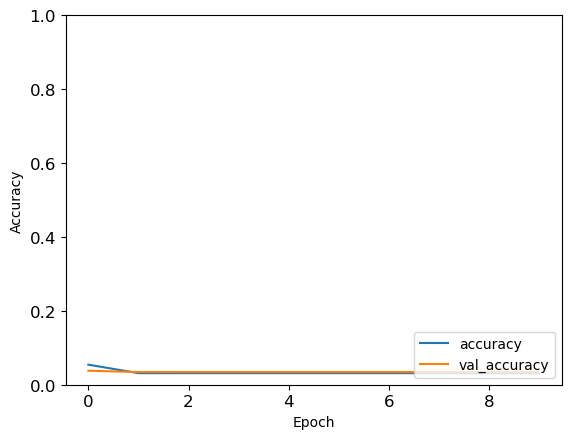

In [ ]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex4, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M3 LR 0.001 linear',epochs,batch_size)
plotHistory(history)

In [ ]:
def create_cnn_ex6(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='selu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='selu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='selu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='selu'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\139781637.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex6, input_shape=input_shape,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

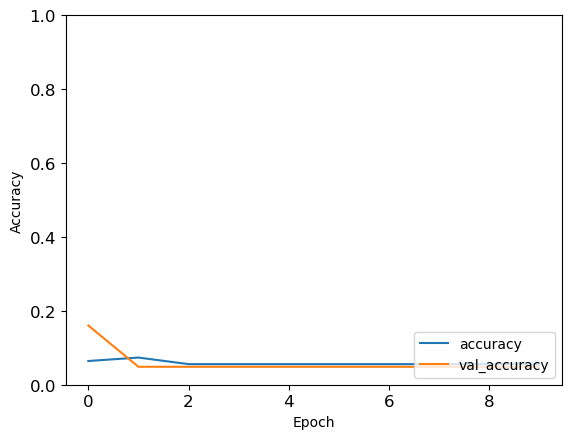

In [ ]:

model = KerasClassifier(build_fn=create_cnn_ex6, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M5 LR 0.001',epochs,batch_size)

plotHistory(history)


In [ ]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.213416,0.204334,0.213592
1,M1 LR 0.01,0.672239,0.954902,0.851780
2,M1 LR 0.001,0.597317,0.983282,0.915534
3,M1 LR 0.0001,0.388751,0.710010,0.618447
4,M1 LR 0.00001,0.243860,0.415789,0.378964
5,M2 LR 0.001,0.387822,0.940351,0.870227
6,M3 LR 0.001 softmax,0.617028,0.976574,0.912945
7,M3 LR 0.001 sigmoid,0.605986,0.824252,0.788350
8,M3 LR 0.001 linear,0.152941,0.031373,0.034304
9,M5 LR 0.001,0.146027,0.055728,0.048544


### GridSearchCV for finding the best parameters

In [ ]:

from sklearn.model_selection import ParameterGrid

param_grid = {
    'epochs': [1,2,5],
    'learning_rate': [0.001],
    'kernel': [(3, 3), (5, 5)],
    'strides': [(1, 1), (2, 2)],
    'dense_units': [64, 128],
}
i=0
best_accuracy = 0
best_params = {}
for params in ParameterGrid(param_grid):
    print(i)
    model = KerasClassifier(build_fn=create_cnn_ex2, **params)
    results_dict, history = cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  f'M3 CVsearch {i}',epochs,batch_size)
    if results_dict['Test_accuracy'] > best_accuracy:
        best_accuracy = results_dict['Test_accuracy']
        best_params = params
    i+=1


best_params = {'dense_units': 64,'kernel': (5, 5),'learning_rate': 0.001,'strides': (1, 1)}


In [ ]:
results_df

In [ ]:
best_params

In [ ]:
best_params.pop('epochs')

## Exploring the Best Model found

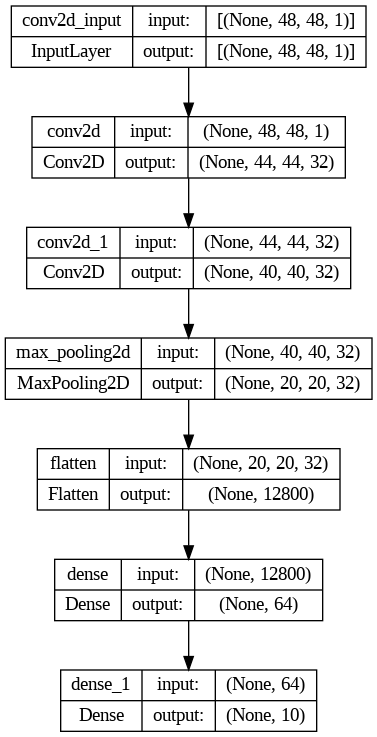

In [ ]:
from tensorflow import keras

best_model = create_cnn_ex2(**best_params)
keras.utils.plot_model(best_model , show_shapes=True)

In [ ]:
best_params = {'dense_units': 64,
 'kernel': (5, 5),
 'learning_rate': 0.001,
 'strides': (1, 1)}

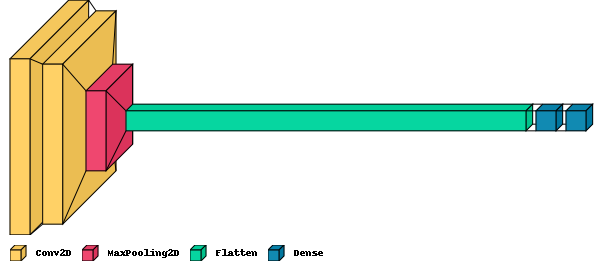

In [ ]:
import visualkeras

visualkeras.layered_view(best_model , legend=True)


C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\2466078748.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **best_params)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

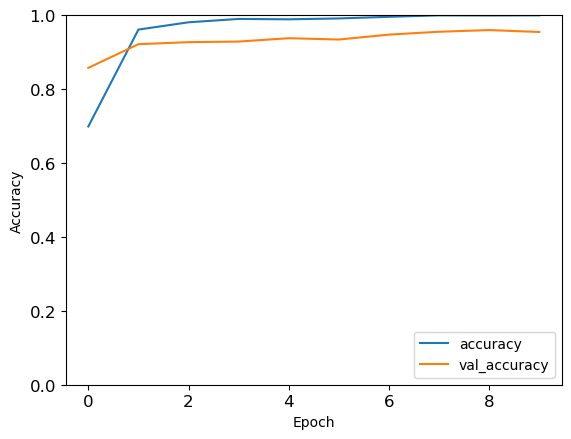

In [ ]:

model = KerasClassifier(build_fn=create_cnn_ex2, **best_params)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M3 Best 0.001',epochs=epochs,batch_size=batch_size)
plotHistory(history)



In [ ]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.213416,0.204334,0.213592
1,M1 LR 0.01,0.672239,0.954902,0.851780
2,M1 LR 0.001,0.597317,0.983282,0.915534
3,M1 LR 0.0001,0.388751,0.710010,0.618447
4,M1 LR 0.00001,0.243860,0.415789,0.378964
5,M2 LR 0.001,0.387822,0.940351,0.870227
6,M3 LR 0.001 softmax,0.617028,0.976574,0.912945
7,M3 LR 0.001 sigmoid,0.605986,0.824252,0.788350
8,M3 LR 0.001 linear,0.152941,0.031373,0.034304
9,M5 LR 0.001,0.146027,0.055728,0.048544


In [ ]:
results_df.to_csv("results_df_final", sep=',', index=False, encoding='utf-8')

#### Adding layers to the best model

In [ ]:
def create_cnn_ex2_added_layers(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


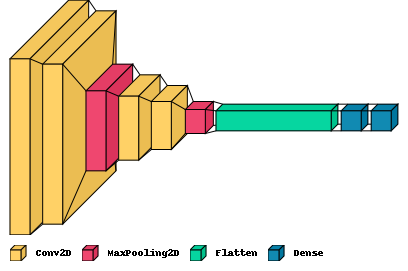

In [ ]:
import visualkeras
visualkeras.layered_view( create_cnn_ex2_added_layers(**best_params), legend=True)


C:\Users\Poornima\AppData\Local\Temp\ipykernel_14560\1551632283.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  layers_added_best_model = KerasClassifier(build_fn=create_cnn_ex2_added_layers, **best_params)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

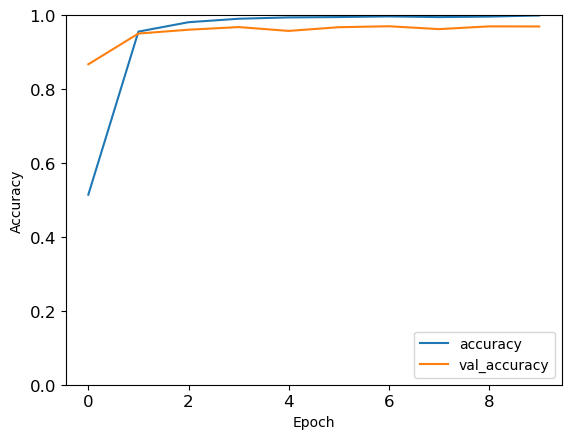

In [ ]:
layers_added_best_model = KerasClassifier(build_fn=create_cnn_ex2_added_layers, **best_params)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,layers_added_best_model,
                                                  'M3 Best 0.001 Added layers',epochs=epochs,batch_size=batch_size)
plotHistory(history)

In [ ]:
y_pred = layers_added_best_model.predict(x_test_reshaped)

df = calculate_metrics_and_mean(x_test_reshaped, y_test, y_pred, model)


97/97 [==============================] - 6s 58ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 [==============================] - 12s 129ms/step - loss: 1.5560 - accuracy: 0.4275
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: clo

In [ ]:
df

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC,accuracy,CV mean,CV std
0,1.000000,0.733333,0.846154,0.733333,0.000000,1.000000,0.733333,0.994263,0.969256,3.09288,1.986389
1,0.929870,0.994444,0.961074,0.994444,0.022785,0.977215,0.994444,0.996560,NaN,NaN,NaN
2,0.972692,0.997333,0.984858,0.997333,0.008974,0.991026,0.997333,0.997328,NaN,NaN,NaN
3,0.997758,0.988889,0.993304,0.988889,0.000379,0.999621,0.988889,0.999603,NaN,NaN,NaN
4,0.981221,0.950000,0.965358,0.950000,0.004938,0.995062,0.950000,0.997986,NaN,NaN,NaN
5,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
6,0.978022,0.988889,0.983425,0.988889,0.000667,0.999333,0.988889,0.999919,NaN,NaN,NaN
7,1.000000,0.500000,0.666667,0.500000,0.000000,1.000000,0.500000,0.997019,NaN,NaN,NaN
8,0.993197,0.973333,0.983165,0.973333,0.000340,0.999660,0.973333,0.997272,NaN,NaN,NaN
9,0.957447,1.000000,0.978261,1.000000,0.001333,0.998667,1.000000,0.999522,NaN,NaN,NaN


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

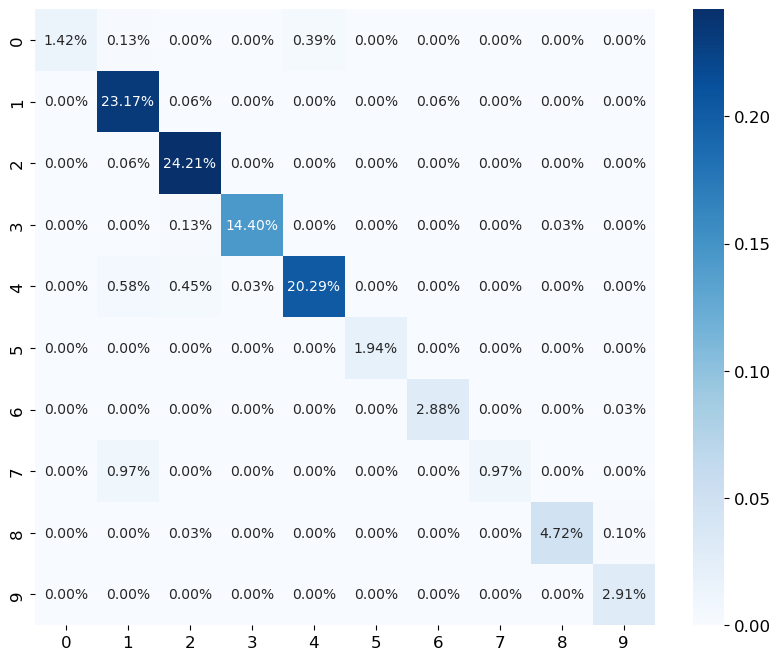

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix_train = confusion_matrix(y_test,y_pred )
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_train/np.sum(confusion_matrix_train), annot=True,  fmt='.2%', cmap='Blues')
plt.tight_layout

In [ ]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.213416,0.204334,0.213592
1,M1 LR 0.01,0.672239,0.954902,0.851780
2,M1 LR 0.001,0.597317,0.983282,0.915534
3,M1 LR 0.0001,0.388751,0.710010,0.618447
4,M1 LR 0.00001,0.243860,0.415789,0.378964
5,M2 LR 0.001,0.387822,0.940351,0.870227
6,M3 LR 0.001 softmax,0.617028,0.976574,0.912945
7,M3 LR 0.001 sigmoid,0.605986,0.824252,0.788350
8,M3 LR 0.001 linear,0.152941,0.031373,0.034304
9,M5 LR 0.001,0.146027,0.055728,0.048544


### Comparing accuracy of all models

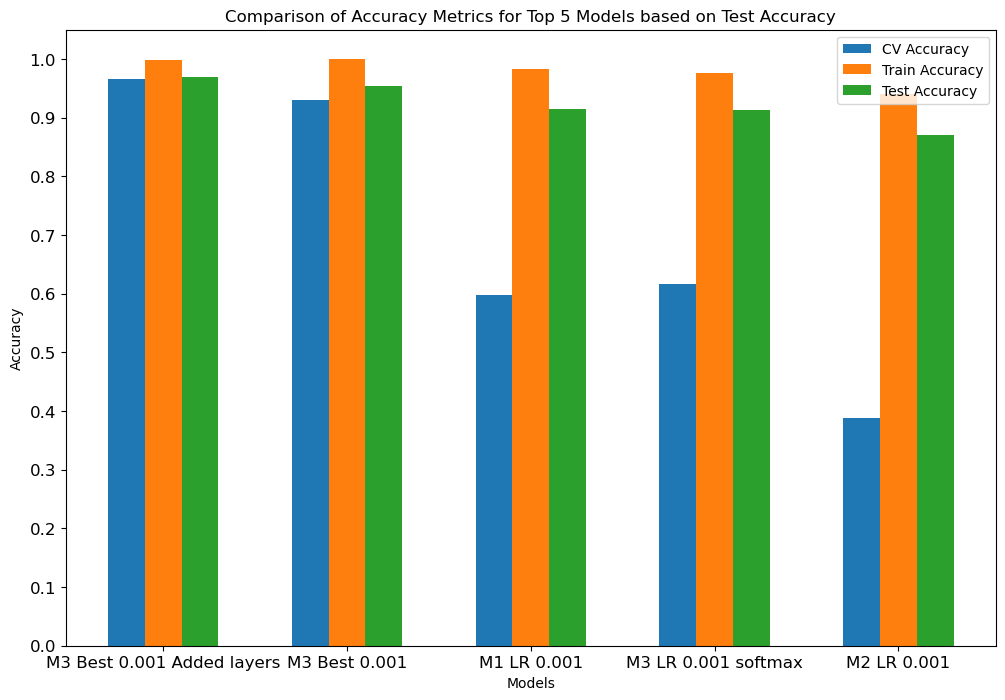

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))

# Sorting results dataframe such that test accuracy is high to low
sorted_results = results_df.sort_values(by='Test_accuracy', ascending=False)

top_5_results = sorted_results.head(5)


models = top_5_results['Model']
cv_accuracy = top_5_results['CV10_Mean_Accuracy']
train_accuracy = top_5_results['Train_accuracy']
test_accuracy = top_5_results['Test_accuracy']


bar_width = 0.2
index = range(len(models))

plt.bar(index, cv_accuracy, width=bar_width, label='CV Accuracy')
plt.bar([i + bar_width for i in index], train_accuracy, width=bar_width, label='Train Accuracy')
plt.bar([i + 2 * bar_width for i in index], test_accuracy, width=bar_width, label='Test Accuracy')

plt.yticks([i/10 for i in range(11)])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Metrics for Top 5 Models based on Test Accuracy')
plt.xticks([i + bar_width for i in index], models)
plt.legend()

plt.show()



### Visualizing CNN

In [ ]:
keras_model = layers_added_best_model.model
keras_model.summary()

Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_206 (Conv2D)         (None, 44, 44, 32)        832       
                                                                 
 conv2d_207 (Conv2D)         (None, 40, 40, 32)        25632     
                                                                 
 max_pooling2d_136 (MaxPooli  (None, 20, 20, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_208 (Conv2D)         (None, 16, 16, 32)        25632     
                                                                 
 conv2d_209 (Conv2D)         (None, 12, 12, 32)        25632     
                                                                 
 max_pooling2d_137 (MaxPooli  (None, 6, 6, 32)         0         
 ng2D)                                              

#### Visualizing layers

(5, 5, 32, 32) -0.2800819 0.18579265


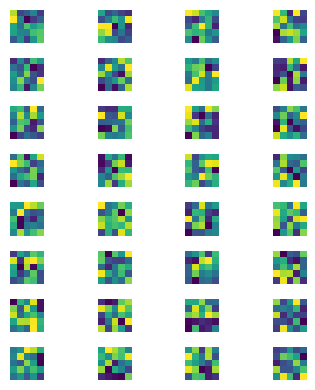

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

def display_filters(model, layer_name, cols=5, interpolation=None):

    layer = model.get_layer(layer_name)
    weights = layer.get_weights()[0]
    print(weights.shape, weights.min(), weights.max())


    rows = math.ceil(weights.shape[3] / cols)
    plt.figure(figsize=(4,4))

    i = 1
    for j in range(weights.shape[3]):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Display each filter
        plt.imshow(weights[:, :, 0, j], interpolation=interpolation)
        i += 1
    plt.tight_layout()
    plt.show()


layer_name = 'conv2d_209'
display_filters(layers_added_best_model.model, layer_name, cols=4 , interpolation="None")




### Running the best model on randomized images

97/97 [==============================] - 2s 25ms/step
Overall Test Accuracy: 0.9692556634304207


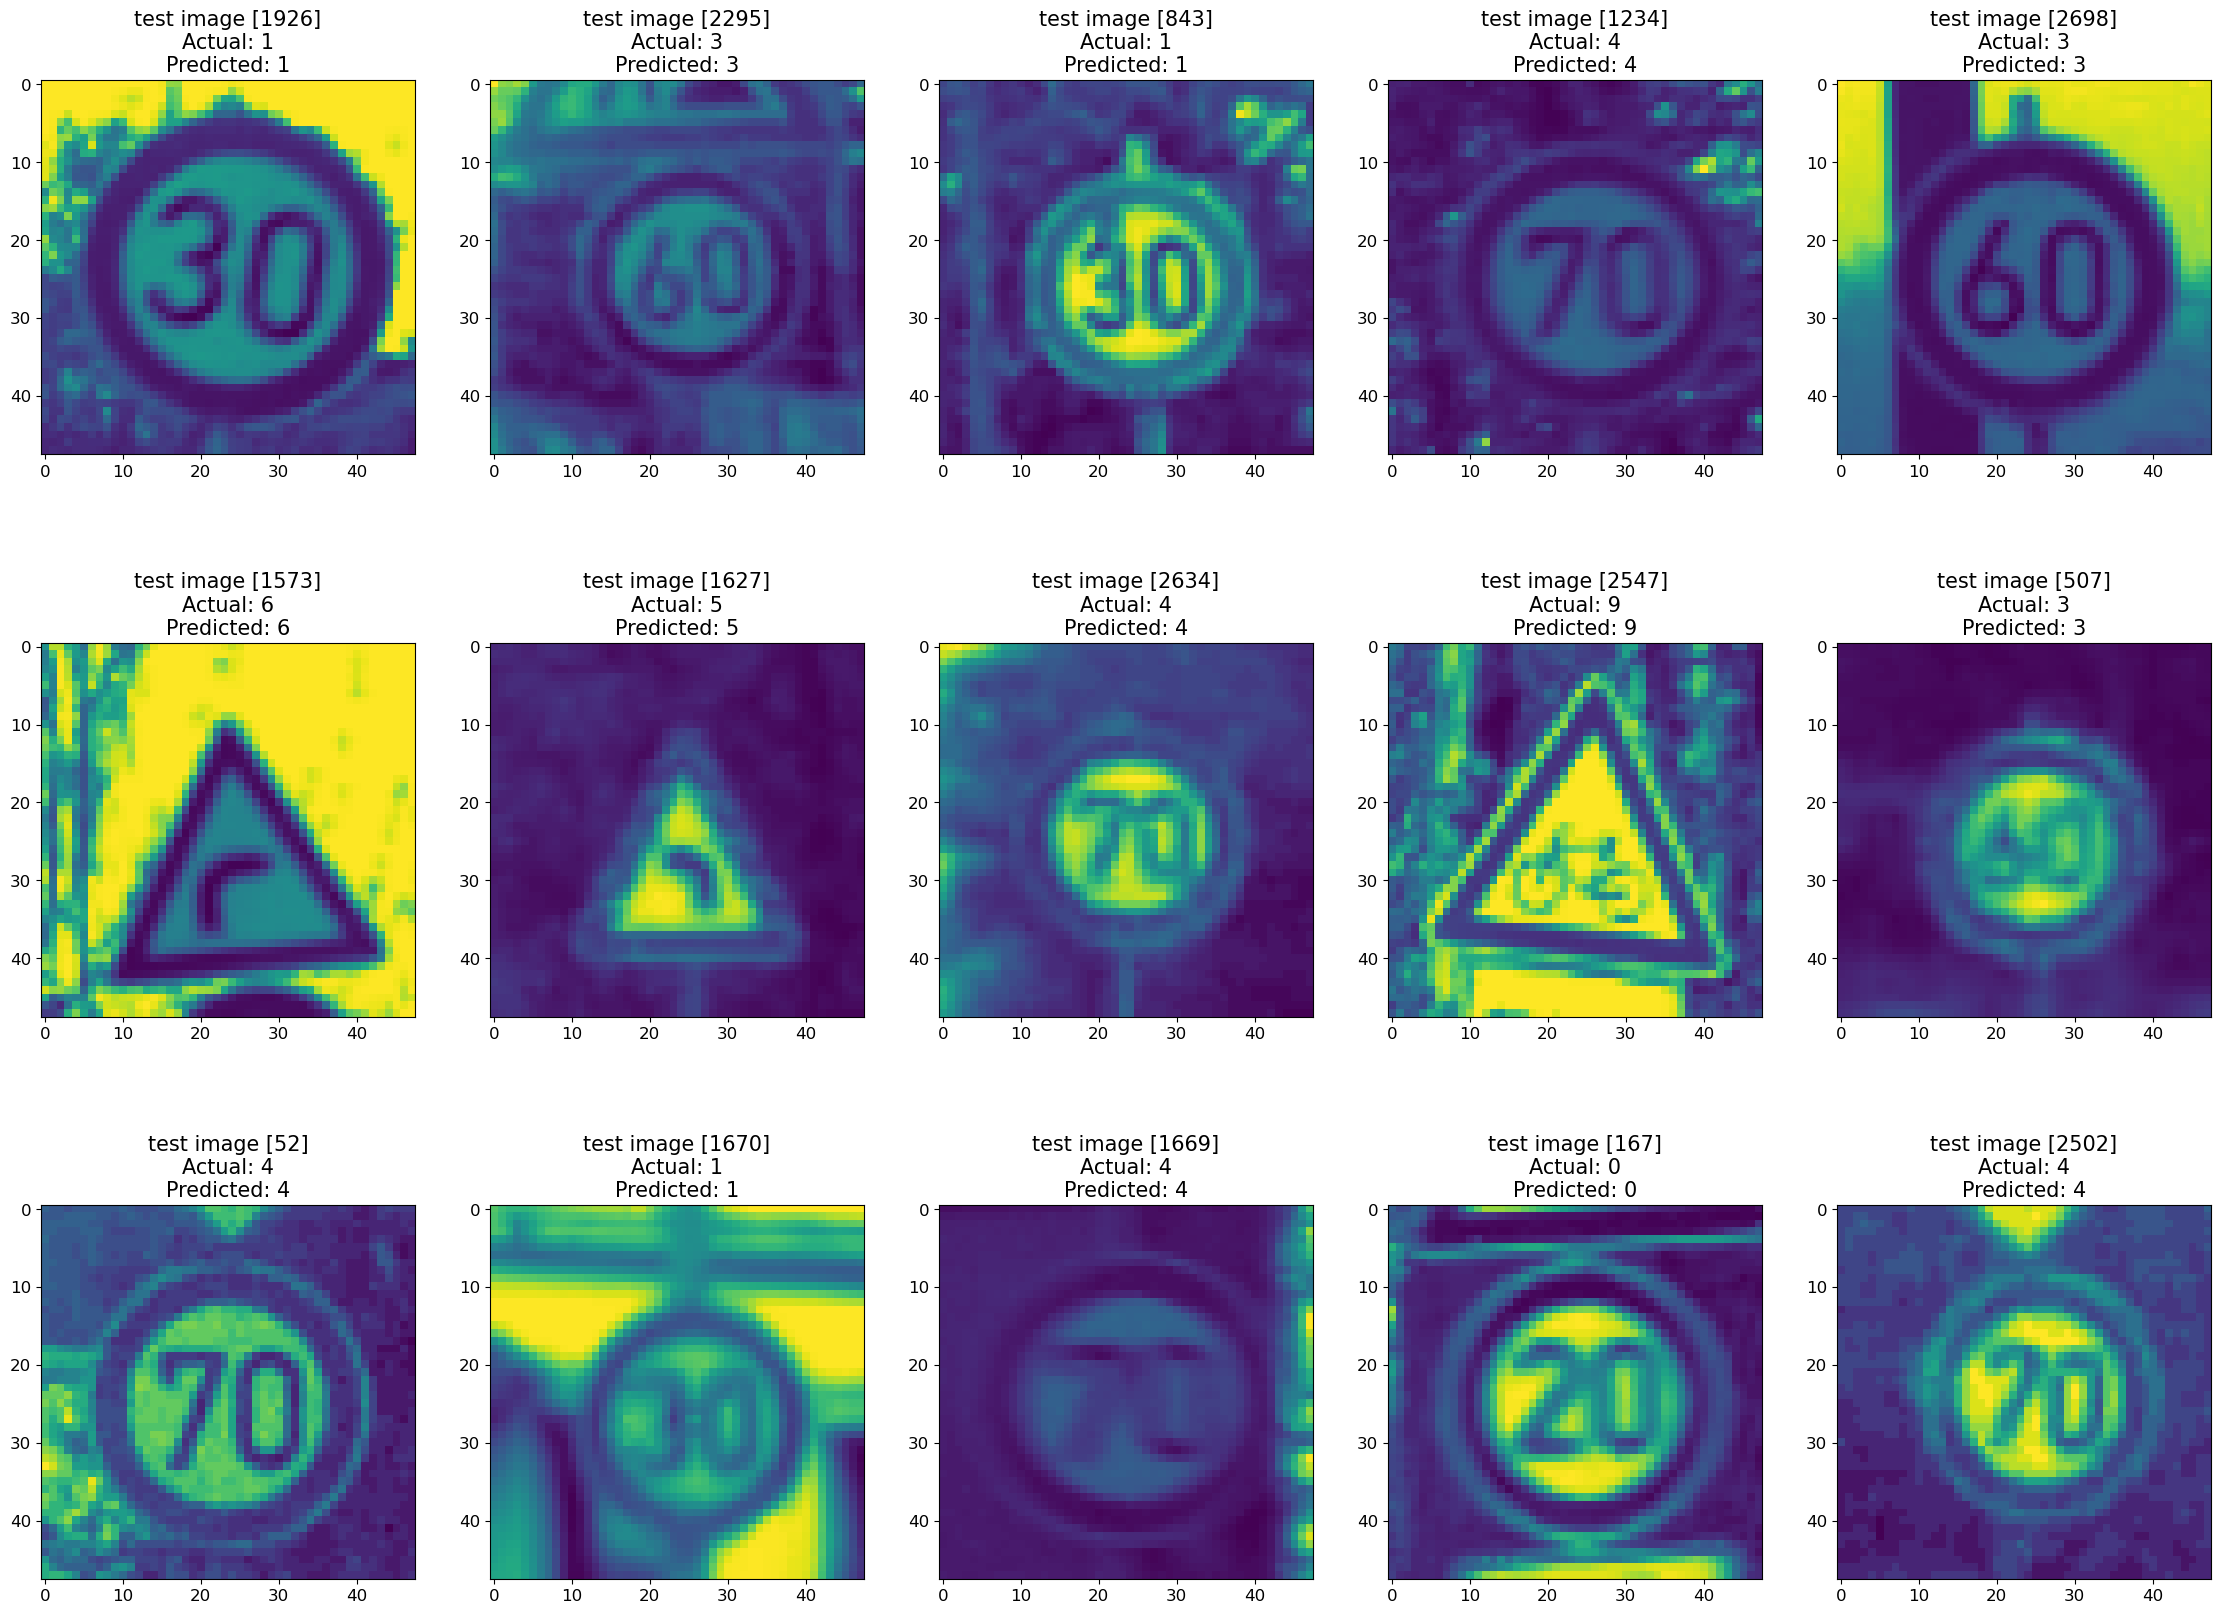

In [ ]:
# Done 15 random images on the Test Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import accuracy_score


def show_images_with_predictions(images, actual_values, predicted_values, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1

    for x in zip(images, actual_values, predicted_values, title_texts):
        image = x[0]
        actual_value = x[1]
        predicted_value = x[2]
        title_text = x[3]
        plt.subplot(rows, cols, index)


        height, width = int(np.sqrt(len(image))), int(np.sqrt(len(image)))
        image = image.reshape((height, width))

        plt.imshow(image)

        # Text showing actual and predicted value
        title_text += f'\nActual: {actual_value}\nPredicted: {predicted_value}'

        if (title_text != ''):
            plt.title(title_text, fontsize=15)
        index += 1


random_images = []
predicted_values = layers_added_best_model.predict(x_test_reshaped)
actual_values = y_test

for i in range(0, 15):
    r = random.randint(0, len(x_test) - 1)
    random_images.append((x_test.iloc[r].values, actual_values.iloc[r,0], predicted_values[r], 'test image [' + str(r) + ']'))

show_images_with_predictions(list(map(lambda x: x[0], random_images)),
                              list(map(lambda x: x[1], random_images)),
                              list(map(lambda x: x[2], random_images)),
                              list(map(lambda x: x[3], random_images)))

# Calculate overall accuracy
test_accuracy = accuracy_score(actual_values, predicted_values)
print(f"Overall Test Accuracy: {test_accuracy}")

## Existing CNN Architectures

In [ ]:
x_train_array = np.array(x_train)
x_train_reshaped = x_train_array.reshape(-1, 48, 48, 1)
x_train_reshaped = np.repeat(x_train_reshaped, 3, axis=-1)

x_test_array = np.array(x_test)
x_test_reshaped = x_test_array.reshape(-1, 48, 48, 1)
x_test_reshaped = np.repeat(x_test_reshaped, 3, axis=-1)

In [ ]:

overall_metrics = pd.DataFrame()

def performance_display(x_test, y_test, y_pred, model, model_name):
    global overall_metrics

    metrics_df = calculate_metrics_and_mean(x_test_reshaped, y_test, y_pred, model)
    drop_labels = ["AUC","CV mean","CV std"]
    metrics_df= metrics_df.drop(columns=drop_labels)
    last_row =  metrics_df.tail(1)
    last_row.insert(0, "Name", model_name, True)
    overall_metrics = pd.concat([overall_metrics,last_row], ignore_index=True)


    return overall_metrics


#### vgg16


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16

import numpy as np
from sklearn.metrics import accuracy_score

In [ ]:
epochs=10

In [ ]:
vgg16_model = Sequential()
vgg16_model.add(VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3)))
vgg16_model.add(Flatten())
vgg16_model.add(Dense(1024, activation='relu'))
vgg16_model.add(Dense(10, activation='softmax'))

In [ ]:
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
vgg16_model.fit(x_train_reshaped, y_train, epochs=epochs, validation_data=(x_test_reshaped, y_test))


Epoch 1/10
303/303 [==============================] - 121s 380ms/step - loss: 1.9472 - accuracy: 0.3099 - val_loss: 1.4710 - val_accuracy: 0.4379
Epoch 2/10
303/303 [==============================] - 112s 370ms/step - loss: 0.6891 - accuracy: 0.7599 - val_loss: 0.4727 - val_accuracy: 0.8427
Epoch 3/10
303/303 [==============================] - 113s 374ms/step - loss: 0.2471 - accuracy: 0.9267 - val_loss: 0.2958 - val_accuracy: 0.9000
Epoch 4/10
303/303 [==============================] - 113s 374ms/step - loss: 0.1304 - accuracy: 0.9613 - val_loss: 0.2171 - val_accuracy: 0.9417
Epoch 5/10
303/303 [==============================] - 113s 374ms/step - loss: 0.1449 - accuracy: 0.9602 - val_loss: 0.3427 - val_accuracy: 0.9091
Epoch 6/10
303/303 [==============================] - 113s 374ms/step - loss: 0.0947 - accuracy: 0.9769 - val_loss: 0.1391 - val_accuracy: 0.9660
Epoch 7/10
303/303 [==============================] - 113s 372ms/step - loss: 0.1036 - accuracy: 0.9776 - val_loss: 0.2288 -

In [ ]:
y_pred_prob = vgg16_model.predict(x_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

97/97 [==============================] - 13s 131ms/step


In [ ]:
#print(f"{classification_report(y_test, y_pred,target_names=['class '+ str(i) for i in range(0,10)])} \n")

In [ ]:
performance_display(x_test_reshaped, y_test, y_pred, vgg16_model, "vgg16")

,Name,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy
0,vgg16,0.904609,0.892182,0.879631,0.892182,0.005409,0.994591,0.892182,0.952427


#### MobileNetV2


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

mobilenetv2_model = Sequential()
mobilenetv2_model.add(MobileNetV2(weights='imagenet', include_top=False, input_shape=(48, 48, 3)))
mobilenetv2_model.add(GlobalAveragePooling2D())
mobilenetv2_model.add(Dense(1024, activation='relu'))
mobilenetv2_model.add(Dense(10, activation='softmax'))


In [ ]:
mobilenetv2_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
mobilenetv2_model.fit(x_train_reshaped, y_train, epochs=epochs, validation_data=(x_test_reshaped, y_test))


Epoch 1/10
303/303 [==============================] - 58s 133ms/step - loss: 0.8238 - accuracy: 0.7463 - val_loss: 9.0610 - val_accuracy: 0.4657
Epoch 2/10
303/303 [==============================] - 38s 126ms/step - loss: 0.1874 - accuracy: 0.9483 - val_loss: 5.5935 - val_accuracy: 0.6036
Epoch 3/10
303/303 [==============================] - 38s 125ms/step - loss: 0.1145 - accuracy: 0.9676 - val_loss: 3.1732 - val_accuracy: 0.7987
Epoch 4/10
303/303 [==============================] - 38s 126ms/step - loss: 0.0533 - accuracy: 0.9843 - val_loss: 4.3336 - val_accuracy: 0.7049
Epoch 5/10
303/303 [==============================] - 38s 127ms/step - loss: 0.0523 - accuracy: 0.9864 - val_loss: 1.4882 - val_accuracy: 0.8443
Epoch 6/10
303/303 [==============================] - 38s 125ms/step - loss: 0.0245 - accuracy: 0.9939 - val_loss: 1.2879 - val_accuracy: 0.9104
Epoch 7/10
303/303 [==============================] - 38s 125ms/step - loss: 0.0621 - accuracy: 0.9863 - val_loss: 1.4057 - val_ac

In [ ]:
y_pred_prob = mobilenetv2_model.predict(x_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

97/97 [==============================] - 3s 26ms/step


In [ ]:
performance_display(x_test_reshaped, y_test, y_pred, mobilenetv2_model, "mobilenetV2")

,Name,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy
0,vgg16,0.904609,0.892182,0.879631,0.892182,0.005409,0.994591,0.892182,0.952427
1,mobilenetV2,0.931176,0.908795,0.907024,0.908795,0.004054,0.995946,0.908795,0.965049


#### DenseNet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

densenet_model = Sequential()
densenet_model.add(DenseNet121(weights='imagenet', include_top=False, input_shape=(48, 48, 3)))
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(Dense(1024, activation='relu'))
densenet_model.add(Dense(10, activation='softmax'))


In [ ]:
densenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
densenet_model.fit(x_train_reshaped, y_train, epochs=epochs, validation_data=(x_test_reshaped, y_test))


Epoch 1/10
303/303 [==============================] - 137s 307ms/step - loss: 0.3503 - accuracy: 0.8928 - val_loss: 0.7123 - val_accuracy: 0.9168
Epoch 2/10
303/303 [==============================] - 88s 290ms/step - loss: 0.0695 - accuracy: 0.9813 - val_loss: 0.0555 - val_accuracy: 0.9812
Epoch 3/10
303/303 [==============================] - 88s 290ms/step - loss: 0.0452 - accuracy: 0.9875 - val_loss: 0.0357 - val_accuracy: 0.9906
Epoch 4/10
303/303 [==============================] - 88s 292ms/step - loss: 0.0490 - accuracy: 0.9888 - val_loss: 0.5049 - val_accuracy: 0.8981
Epoch 5/10
303/303 [==============================] - 88s 290ms/step - loss: 0.0368 - accuracy: 0.9897 - val_loss: 0.1422 - val_accuracy: 0.9602
Epoch 6/10
303/303 [==============================] - 88s 289ms/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.2918 - val_accuracy: 0.9184
Epoch 7/10
303/303 [==============================] - 88s 289ms/step - loss: 0.0174 - accuracy: 0.9947 - val_loss: 0.0820 - val_a

In [ ]:
y_pred_prob = densenet_model.predict(x_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

97/97 [==============================] - 9s 82ms/step


In [ ]:
performance_display(x_test_reshaped, y_test, y_pred, densenet_model, "DenseNet121")

,Name,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy
0,vgg16,0.904609,0.892182,0.879631,0.892182,0.005409,0.994591,0.892182,0.952427
1,mobilenetV2,0.931176,0.908795,0.907024,0.908795,0.004054,0.995946,0.908795,0.965049
2,DenseNet121,0.968954,0.910861,0.928552,0.910861,0.002935,0.997065,0.910861,0.975728


#### ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

resnet_model = Sequential()
resnet_model.add(ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3)))
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(10, activation='softmax'))

In [ ]:
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
resnet_model.fit(x_train_reshaped, y_train, epochs=epochs, validation_data=(x_test_reshaped, y_test))


Epoch 1/10
303/303 [==============================] - 119s 319ms/step - loss: 0.4914 - accuracy: 0.8677 - val_loss: 0.6982 - val_accuracy: 0.9278
Epoch 2/10
303/303 [==============================] - 93s 308ms/step - loss: 0.1568 - accuracy: 0.9633 - val_loss: 0.1452 - val_accuracy: 0.9612
Epoch 3/10
303/303 [==============================] - 93s 308ms/step - loss: 0.0575 - accuracy: 0.9845 - val_loss: 0.1309 - val_accuracy: 0.9602
Epoch 4/10
303/303 [==============================] - 94s 311ms/step - loss: 0.0346 - accuracy: 0.9908 - val_loss: 1.0541 - val_accuracy: 0.7282
Epoch 5/10
303/303 [==============================] - 94s 309ms/step - loss: 0.0689 - accuracy: 0.9832 - val_loss: 0.0956 - val_accuracy: 0.9754
Epoch 6/10
303/303 [==============================] - 94s 310ms/step - loss: 0.0325 - accuracy: 0.9909 - val_loss: 0.1136 - val_accuracy: 0.9806
Epoch 7/10
303/303 [==============================] - 94s 309ms/step - loss: 0.0461 - accuracy: 0.9902 - val_loss: 0.1406 - val_a

In [ ]:
y_pred_prob = resnet_model.predict(x_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

97/97 [==============================] - 11s 104ms/step


In [ ]:
performance_display(x_test_reshaped, y_test, y_pred, resnet_model, "ResNet50")

,Name,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy
0,vgg16,0.904609,0.892182,0.879631,0.892182,0.005409,0.994591,0.892182,0.952427
1,mobilenetV2,0.931176,0.908795,0.907024,0.908795,0.004054,0.995946,0.908795,0.965049
2,DenseNet121,0.968954,0.910861,0.928552,0.910861,0.002935,0.997065,0.910861,0.975728
3,ResNet50,0.744755,0.765892,0.733559,0.765892,0.008469,0.991531,0.765892,0.924919


### Comparing performances

In [ ]:
overall_metrics

,Name,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy
0,vgg16,0.904609,0.892182,0.879631,0.892182,0.005409,0.994591,0.892182,0.952427
1,mobilenetV2,0.931176,0.908795,0.907024,0.908795,0.004054,0.995946,0.908795,0.965049
2,DenseNet121,0.968954,0.910861,0.928552,0.910861,0.002935,0.997065,0.910861,0.975728
3,ResNet50,0.744755,0.765892,0.733559,0.765892,0.008469,0.991531,0.765892,0.924919
